# Import statements 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from  my_ml_lib import MetricTools, PlotTools

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [6]:
import cv2

# Saving and Loading code 

In [7]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [8]:
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/train.pkl"
x = load(data_path)

In [9]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [10]:
save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [11]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [12]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [14]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [15]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [16]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [17]:
batch = 64
train_dataset = myDataClass(X_train, y_train)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [18]:
# next(iter(train_dataloader))[0].shape

In [19]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [20]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [21]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [22]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [23]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] 

## CNN - Block-1 

### model 

In [26]:
cfg1 = {
    'B1': [16,16,'M'],
}

In [27]:
def make_layers1(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=4, stride=3)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(1,2),padding=(0,1))]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [28]:
class Model_B1(nn.Module):

    def __init__(self, features):

        super(Model_B1, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 64),
            
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [30]:
# m = Model_B1(make_layers1(cfg1['B1']))
# for i,l in train_dataloader:
#   o = m(i)

In [31]:
model1 = Model_B1(make_layers1(cfg1['B1'])).to(device) 
learning_rate = 0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
print(model1)

Model_B1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


###train

In [ ]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block1/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block1/'

In [32]:
save_path1 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block1/"

In [33]:

# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1

m, train_losses, val_losses,m_all_models = train(save_path1,100,train_dataloader,model1,test_dataloader,optimizer1,criterion1,"cnn_b1")

Epoch: 1 	Training Loss: 2.205485 	Validation Loss: 1.905731 Test Accuracy: 0.336
Saving model..1
Epoch: 2 	Training Loss: 1.826890 	Validation Loss: 1.909092 Test Accuracy: 0.324
Epoch: 3 	Training Loss: 1.744764 	Validation Loss: 1.565192 Test Accuracy: 0.419
Saving model..2
Epoch: 4 	Training Loss: 1.625529 	Validation Loss: 1.513360 Test Accuracy: 0.472
Saving model..3
Epoch: 5 	Training Loss: 1.605397 	Validation Loss: 1.558328 Test Accuracy: 0.419
Epoch: 6 	Training Loss: 1.599407 	Validation Loss: 1.463705 Test Accuracy: 0.500
Saving model..4
Epoch: 7 	Training Loss: 1.505331 	Validation Loss: 1.393476 Test Accuracy: 0.518
Saving model..5
Epoch: 8 	Training Loss: 1.454882 	Validation Loss: 1.425164 Test Accuracy: 0.513
Epoch: 9 	Training Loss: 1.407278 	Validation Loss: 1.414301 Test Accuracy: 0.497
Epoch: 10 	Training Loss: 1.393161 	Validation Loss: 1.257278 Test Accuracy: 0.564
Saving model..6
Epoch: 11 	Training Loss: 1.378350 	Validation Loss: 1.322412 Test Accuracy: 0.549


### Plots and test 

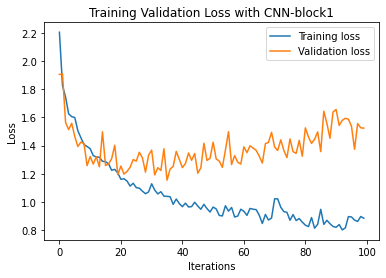

In [34]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [35]:
all_models1 = load(save_path1 + "cnn_b1_all_models.pkl")
FILE  = all_models1[-1]
m = Model_B1(make_layers1(cfg1['B1'])).to(device) 

In [36]:
m = load_best(all_models1,m)

In [37]:
train_y, train_y_hat = test(train_dataloader, m, criterion1, device, "TRAIN")

TRAIN Loss: 0.733357

TRAIN Accuracy: 73% (3322/4500)


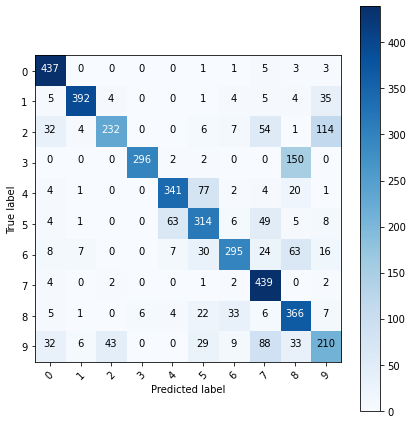

In [38]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [39]:
test_y, test_y_hat = test(test_dataloader, m, criterion1, device,"TEST")

TEST Loss: 1.163685

TEST Accuracy: 60% (302/500)


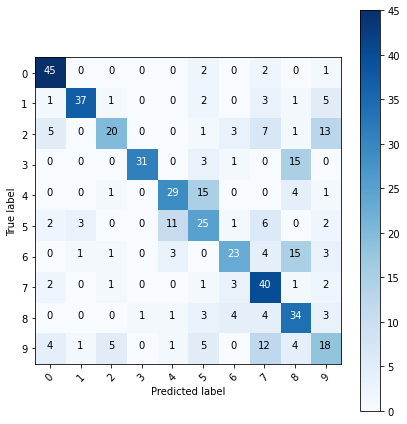

In [40]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block12

### model 

In [41]:
cfg2 = {
    'B12': [16,16,'M', 32, 32, 32,'M'],
}

In [42]:
def make_layers2(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1,padding=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [43]:
class Model_B12(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B12, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.Linear(3200, 512),
            # nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [44]:
# m = Model_B12(make_layers2(cfg2['B12']))
# for i,l in train_dataloader:
#   o = m(i)

In [45]:
model2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 
learning_rate = 0.01
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

Model_B12(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=

### Train 

In [46]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block12/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block12/'

In [47]:
save_path2 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block12/"

In [48]:
m, train_losses, val_losses,m_all_models = train(save_path2,100,train_dataloader,model2,test_dataloader,optimizer2,criterion2,"cnn_b12")

Epoch: 1 	Training Loss: 2.125123 	Validation Loss: 1.886667 Test Accuracy: 0.296
Saving model..1
Epoch: 2 	Training Loss: 1.859016 	Validation Loss: 1.775058 Test Accuracy: 0.358
Saving model..2
Epoch: 3 	Training Loss: 1.740361 	Validation Loss: 2.427932 Test Accuracy: 0.318
Epoch: 4 	Training Loss: 1.698446 	Validation Loss: 1.795038 Test Accuracy: 0.376
Epoch: 5 	Training Loss: 1.605549 	Validation Loss: 1.590892 Test Accuracy: 0.422
Saving model..3
Epoch: 6 	Training Loss: 1.537563 	Validation Loss: 1.494685 Test Accuracy: 0.481
Saving model..4
Epoch: 7 	Training Loss: 1.476603 	Validation Loss: 1.434296 Test Accuracy: 0.472
Saving model..5
Epoch: 8 	Training Loss: 1.421502 	Validation Loss: 1.536880 Test Accuracy: 0.492
Epoch: 9 	Training Loss: 1.418234 	Validation Loss: 1.414786 Test Accuracy: 0.511
Saving model..6
Epoch: 10 	Training Loss: 1.349470 	Validation Loss: 1.320384 Test Accuracy: 0.539
Saving model..7
Epoch: 11 	Training Loss: 1.286781 	Validation Loss: 1.416316 Test 

### Test and Plots 

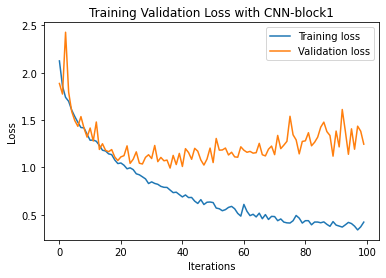

In [49]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [50]:
all_models2 = load(save_path2 + "cnn_b12_all_models.pkl")
FILE  = all_models2[-1]
m2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 

In [51]:
m2 = load_best(all_models2,m2)

In [52]:
train_y, train_y_hat = test(train_dataloader, m2, criterion2, device, "TRAIN")

TRAIN Loss: 0.558794

TRAIN Accuracy: 81% (3646/4500)


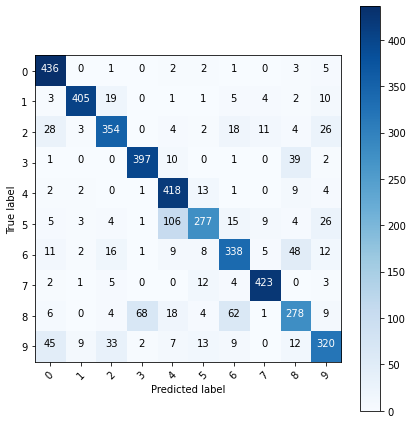

In [53]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [54]:
test_y, test_y_hat = test(test_dataloader, m2, criterion2, device,"TEST")

TEST Loss: 0.986877

TEST Accuracy: 63% (318/500)


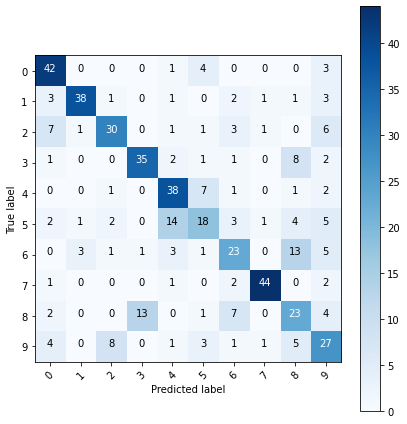

In [55]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block-123

### model 

In [58]:
cfg3 = {
    'B123': [16,16,'M',32,32,32,'M',64,'M'],
}

In [59]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [60]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1024, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        return x

In [61]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [62]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.01
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace

### train 

In [63]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block123/'

In [64]:
save_path3 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_fc/Dropout(0.3)/cnn_block123/"

In [65]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123")

Epoch: 1 	Training Loss: 1.693468 	Validation Loss: 1.536812 Test Accuracy: 0.464
Saving model..1
Epoch: 2 	Training Loss: 1.394654 	Validation Loss: 1.518758 Test Accuracy: 0.472
Saving model..2
Epoch: 3 	Training Loss: 1.253467 	Validation Loss: 1.510952 Test Accuracy: 0.464
Saving model..3
Epoch: 4 	Training Loss: 1.178214 	Validation Loss: 1.532599 Test Accuracy: 0.480
Epoch: 5 	Training Loss: 1.101661 	Validation Loss: 1.186749 Test Accuracy: 0.602
Saving model..4
Epoch: 6 	Training Loss: 0.999458 	Validation Loss: 1.200723 Test Accuracy: 0.577
Epoch: 7 	Training Loss: 0.959603 	Validation Loss: 1.163429 Test Accuracy: 0.591
Saving model..5
Epoch: 8 	Training Loss: 0.877473 	Validation Loss: 1.020203 Test Accuracy: 0.622
Saving model..6
Epoch: 9 	Training Loss: 0.840650 	Validation Loss: 1.050796 Test Accuracy: 0.623
Epoch: 10 	Training Loss: 0.790563 	Validation Loss: 0.895557 Test Accuracy: 0.679
Saving model..7
Epoch: 11 	Training Loss: 0.760392 	Validation Loss: 0.924262 Test 

### Tests and Plots 

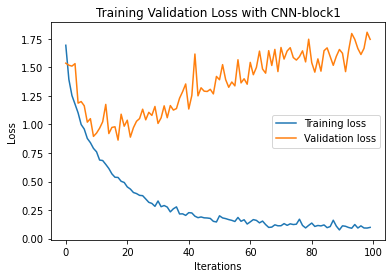

In [66]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [67]:
all_models3 = load(save_path3 + "cnn_b123_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [68]:
m3 = load_best(all_models3,m3)

In [69]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.355316

TRAIN Accuracy: 87% (3946/4500)


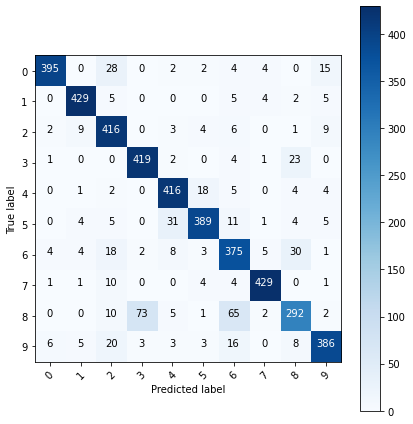

In [70]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [71]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.854087

TEST Accuracy: 70% (353/500)


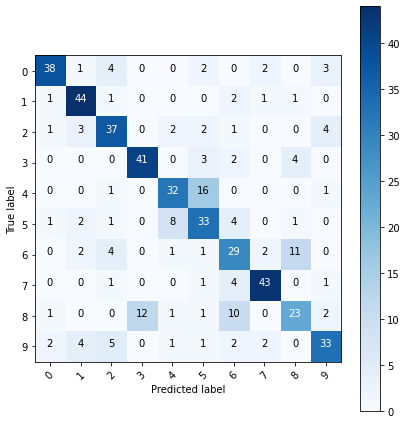

In [72]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))